In [ ]:
### Dependencies instantiation ###

# Only run this cell once, if you haven't run it yet
# This ensures that you have all the necessary dependencies installed

using Pkg
Pkg.activate("../")
Pkg.instantiate()

In [1]:
### Imports ###

include("../src/QuantumPrimer.jl")
using .QuantumPrimer
using Yao
using YaoPlots
using Plots
default(lw=2, ms=5, palette=:Set2_8)
using LinearAlgebra
using Random
using Optimisers
using JLD2
using Combinatorics
using Statistics

#### Examples: run one cell

In [ ]:
### Example: forrelated vs random states ###

n = 4 # preferably a power of 2
data = load("../data/forr_rand_fns_n=$(n).jld2")

forr_f = data["single_stored_object"][1]
rand_f = data["single_stored_object"][2]

forr_batch, forr_samples, forr_vec = size(forr_f, 1), size(forr_f[1], 1), size(forr_f[1][1], 1)
rand_batch, rand_samples, rand_vec = size(rand_f, 1), size(rand_f[1], 1), size(rand_f[1][1], 1)

new_forr_f = zeros(Float64, forr_batch, forr_samples, forr_vec)
new_rand_f = zeros(Float64, rand_batch, rand_samples, rand_vec)

for i in 1:forr_batch
    for j in 1:forr_samples
        new_forr_f[i, j, :] = forr_f[i][j]
        new_rand_f[i, j, :] = rand_f[i][j]
    end
end

####### Change to Int -1, 1 ########
new_forr_f = trunc.(Int64, new_forr_f)
new_rand_f = trunc.(Int64, new_rand_f)
forr_f[1][1][:] ≈ new_forr_f[1,1,:] ? println("Loading data: successful") : println("Loading data: failed")
####################################

seed = 1234 # set seed for reproducibility
Random.seed!(seed)

n_samples = 25
test_ratio = 0.3

states1 = Vector{NTuple{2, ArrayReg}}(undef, 2*n_samples)
states2 = Vector{NTuple{2, ArrayReg}}(undef, 2*n_samples)
psi_zero = zero_state(n)
# psi_zero = zero_state(trunc(Int, log2(n)))
for i in 1:2*n_samples
    states1[i] = (copy(psi_zero) |> circ_hypergraph_state(new_forr_f[i, 1, :]), copy(psi_zero) |> circ_hypergraph_state(new_forr_f[i, 2, :]))
    states2[i] = (copy(psi_zero) |> circ_hypergraph_state(new_rand_f[i, 1, :]), copy(psi_zero) |> circ_hypergraph_state(new_rand_f[i, 2, :]))
end
states1[1][1].state ≈ normalize(new_forr_f[1, 1, :]) ? println("Preparation hypergraph states: successful") : println("Preparation hypergraph states: failed")

inds = 1:2*n_samples
# inds=randperm(2*n_samples)
tr_inds = inds[1:n_samples]
te_inds = inds[n_samples+1:end]

tr_states, te_states = split_train_test(states1, states2, n_samples, test_ratio)
tr_labels = label_states(tr_states, states1, states2)
te_labels = label_states(te_states, states1, states2)

tr_states, tr_labels = shuffle_data(tr_states, tr_labels)
te_states, te_labels = shuffle_data(te_states, te_labels)

tr_data = DataSiamese(tr_states, tr_labels)
te_data = DataSiamese(te_states, te_labels);

In [3]:
# [(state(tr_states[i][1])'*Matrix(circ_gate_n(n,H))*state(tr_states[i][2]))^2 for i in eachindex(tr_states)]

#### Model parameters

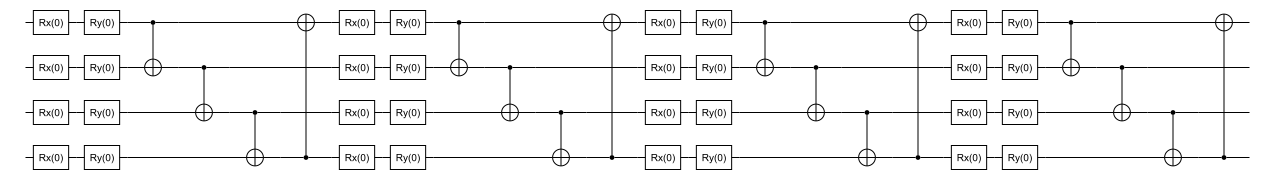

In [24]:
iters = 1000 # number of iterations
lr = 0.01  # learning rate. Start with lr=0.1. Reduce to (e.g. lr=0.01) if optimisation is not smooth.
optim = ADAM(lr) # Descent(lr) # See https://fluxml.ai/Optimisers.jl/dev/api/#Optimisation-Rules for different optimisers.

circ_Z_1st(n) = chain(n,put(1=>Z),put(div(n,2)+1=>Z))
circ_Z_end(n) = chain(n,put(div(n,2)=>Z),put(n=>Z))
circ_swap_1st(n) = chain(n,swap(1,div(n,2)+1))
##### Cost #####
# observables commute with SWAP
# intrinsically evaluating the quantity abs2 of the overlap
# obs_A = chain(2n, put(i=>X) for i = 1:2n) # sum(chain(n, put(i=>X) for i = 1:n))
# obs_B = chain(2n, put(i=>Z) for i = 1:2n) # sum(chain(n, put(i=>Z) for i = 1:n))
# obs_A = chain(2n, put(i=>X) for i in [1,n+1])
# obs_B = chain(2n, put(i=>Z) for i in [1,n+1])
# obs_A = chain(2n, put(i=>H) for i = 1:2n)
# obs_B = chain(2n, put(i=>I2) for i = 1:2n)
# cost_fun = (output, state1, state2; kwargs...) -> covariance_siamese_commuting_obs(output, state1, state2, obs_A, obs_B; kwargs...)
# cost_fun = circ_Z_end
cost_fun = n -> circ_gate_n(n, Z)
# cost_fun = n -> circ_Zsum(n)
# cost_fun = n -> circ_gate_n(n, H)
activation = x -> sigmoid(x, 20, 0.25) # default is identity
# cost = GeneralCost(cost_fun, activation)
# cost = CircuitCost(cost_fun)
cost = CircuitCost(cost_fun, activation)

################

##### QSCNN #####
# # cost = circ_Z # NB: loss and gradients still need to be adjusted for conv siamese
# ansatz = circ_SU4_conv # circ_Ry_conv, circ_Ry_simple_conv, circ_SU4_conv
# circ = build_QCNN(n, ansatz=ansatz)
#################

##### QSNN #####
ansatz = circ_HEA
# ansatz = circ_Rz_layer
depth = 4
circ = build_QNN(n, depth, ansatz=ansatz)
################

##### Model #####
model = GeneralModel(n=n, circ=circ, ansatz=ansatz)
# model = InvariantModel(n=n, circ=circ, ansatz=ansatz) # only valid for QCNN
#################

initialize_params(model);

YaoPlots.plot(circ)
# YaoPlots.plot(cost(n))

#### Run

In [ ]:
model_results = train_test_model(tr_data, te_data, model, cost, iters, optim; regularization=:nothing, verbose=true);
# model_results = train_test_model(tr_data, te_data, model, cost, iters, optim; lambda=1e-2, regularization=:l1, verbose=true);
# model_results = train_test_model(tr_data, te_data, model, cost, iters, optim; lambda=1e-5, regularization=:l2, verbose=true);

model_params, loss_track, tr_track, te_track, tr_preds, te_preds = model_results;

Initial: loss = 1.9093910951390864, tr_acc = 0.48, te_acc = 0.48
Iteration 125: loss = 1.2984642499446741, tr_acc = 0.64, te_acc = 0.5
Iteration 250: loss = 1.2940420809816073, tr_acc = 0.68, te_acc = 0.48
Iteration 375: loss = 0.8133660211974696, tr_acc = 0.78, te_acc = 0.66
Iteration 500: loss = 0.5718120095331057, tr_acc = 0.8, te_acc = 0.76
Iteration 625: loss = 0.22451634156106015, tr_acc = 0.94, te_acc = 0.88
Iteration 750: loss = 0.003056988758608656, tr_acc = 1.0, te_acc = 1.0
Iteration 875: loss = 0.0024214951691031283, tr_acc = 1.0, te_acc = 1.0
Iteration 1000: loss = 0.002148267652970245, tr_acc = 1.0, te_acc = 1.0
Final: loss = 0.002148267652970245, tr_acc = 1.0, te_acc = 1.0


#### Plot

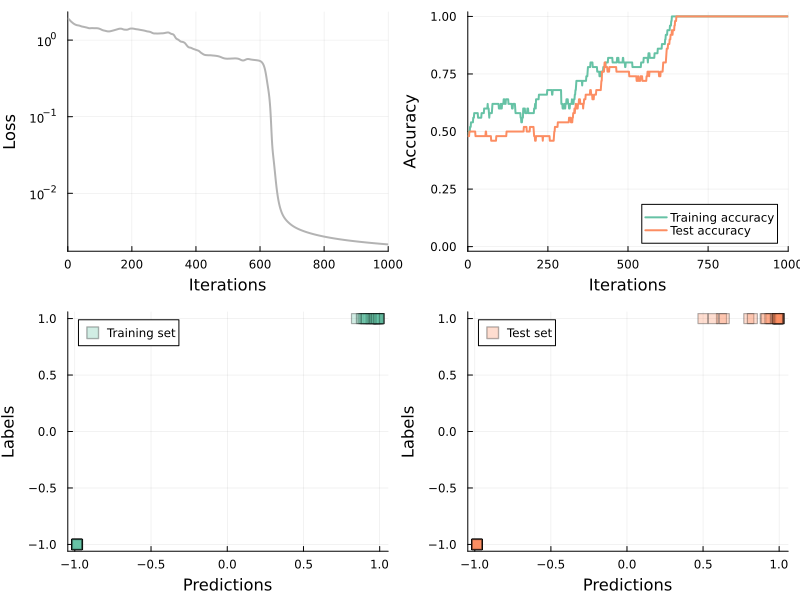

In [26]:
# Loss vs Interations
p1 = Plots.plot(xlim=(0, iters), xlabel="Iterations", ylabel="Loss")
# Plots.hline!([loss_track[1]], label=false, c=0, ylim=(0.9loss_track[1], 1.1loss_track[1]))
Plots.plot!(loss_track, yaxis=:log, label=false, c=0)

# Accuracy vs Interations
p2 = Plots.plot(xlim=(-0.05, iters), ylim=(-0.02, 1.02), xlabel="Iterations", ylabel="Accuracy", legend=:bottomright)
Plots.plot!(tr_track, label="Training accuracy", c=1)
Plots.plot!(te_track, label="Test accuracy", c=2)

# Training labels vs predictions
p3 = Plots.scatter(xlabel="Predictions", ylabel="Labels")
Plots.scatter!(tr_preds, tr_labels, ma=0.3, shape=:rect, label="Training set", c=1)

# Test labels vs predictions
p4 = Plots.scatter(xlabel="Predictions", ylabel="Labels")
Plots.scatter!(te_preds, te_labels, ma=0.3, shape=:rect, label="Test set", c=2)

Plots.plot(p1, p2, p3, p4, layout=(2, 2), size=(800, 600))

In [39]:
savefig("qcsnn_forr_n4_HEA_Zn.pdf")

"c:\\Users\\cu234\\OneDrive - University of Exeter\\Projects\\QComp.jl\\notebooks\\qcsnn_forr_n4_HEA_Zn.pdf"